## Install dependencies

In [1]:
%%capture
!pip install /kaggle/input/torch-geometric/torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl
!pip install /kaggle/input/torch-geometric/torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl
!pip install torch-geometric

## Imports
Import all the modules, we will need later.

In [2]:
import os
import copy
import torch
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from torch_geometric.utils import to_networkx
from torch_geometric.data import Data, DataLoader

import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d
from torch_geometric.nn import GATv2Conv

from types import SimpleNamespace

warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Let's have a look at the data.

In [3]:
df_features = pd.read_csv('/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)
df_edges = pd.read_csv("/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
df_classes =  pd.read_csv("/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
df_classes['class'] = df_classes['class'].map({'unknown': 2, '1': 1, '2': 0})

`df_features` contains each node id and corresponding features.

In [4]:
# nodes features
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


`df_edges` contains list of edges.

In [5]:
# edges
df_edges.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


`df_classes` contains each node id and corresponding class, where *0 - licit, 1 - ilicit* and *2 - unknown*.

In [6]:
# classes
# 0 — legitimate
# 1 — fraud
# 2 — unknown class
df_classes.head()

,txId,class
0,230425980,2
1,5530458,2
2,232022460,2
3,232438397,0
4,230460314,2


Here is the class distribution.

In [7]:
df_classes['class'].value_counts()

class
2    157205
0     42019
1      4545
Name: count, dtype: int64

## Preprocessing
Now, let's convert our data into the `torch_geometric.data.Data` object. First, let's make a dataframe that contains both node features and class.

In [8]:
# merging node features DF with classes DF
df_merge = df_features.merge(df_classes, how='left', right_on="txId", left_on=0)
df_merge = df_merge.sort_values(0).reset_index(drop=True)

Next, we will need edges in a [COO format](https://en.wikipedia.org/wiki/Sparse_matrix#Coordinate_list_(COO)). To do that, we map `edges.txId1` and `edges.txId2` to the indices of the corresponding nodes in a `df_merge`. In the end we store edge indices as `torch.Tensor`.

In [9]:
# mapping nodes to indices
nodes = df_merge[0].values
map_id = {j:i for i,j in enumerate(nodes)}

# mapping edges to indices
edges = df_edges.copy()
edges.txId1 = edges.txId1.map(map_id)
edges.txId2 = edges.txId2.map(map_id)
edges = edges.astype(int)

edge_index = np.array(edges.values).T
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()

# weights for the edges are equal in case of model without attention
weights = torch.tensor([1] * edge_index.shape[1] , dtype=torch.float32)

print("Total amount of edges in DAG:", edge_index.shape)

Total amount of edges in DAG: torch.Size([2, 234355])


Next, we will need node feature matrix. Here we also map each ID to corresponding index. Then, we will store all the unknown nodes in `unclassified_idx`, that's why we remove class 2, since we no longer need it. In the end, we drop everything but features and store it as `torch.Tensor`.

In [10]:
# maping node ids to corresponding indexes
node_features = df_merge.drop(['txId'], axis=1).copy()
node_features[0] = node_features[0].map(map_id)

# store known and unknown nodes
classified_idx = node_features['class'].loc[node_features['class'] != 2].index
unclassified_idx = node_features['class'].loc[node_features['class'] == 2].index

# replace unkown class with 0, to avoid having 3 classes, this data/labels never used in training
node_features['class'] = node_features['class'].replace(2, 0)

labels = node_features['class'].values

# drop indeces, class and temporal axes
node_features = torch.tensor(np.array(node_features.drop([0, 'class', 1], axis=1).values, dtype=np.float32), dtype=torch.float32)

In this cell, we finally create an object of type `torch_geometric.data.Data`. Here, we pass following parameters:
- `x` – Node feature matrix with shape.

- `edge_index` – Graph connectivity in COO format with shape `[2, num_edges]`.

- `edge_attr` – Edge feature matrix with shape `[num_edges, num_edge_features]`.

- `y` – Graph-level or node-level ground-truth labels with arbitrary shape.

We also print a brief description of our network.

In [11]:
# converting data to PyGeometric graph data format
elliptic_dataset = Data(x = node_features,
                        edge_index = edge_index,
                        edge_attr = weights,
                        y = torch.tensor(labels, dtype=torch.float32))

print(f'Number of nodes: {elliptic_dataset.num_nodes}')
print(f'Number of node features: {elliptic_dataset.num_features}')
print(f'Number of edges: {elliptic_dataset.num_edges}')
print(f'Number of edge features: {elliptic_dataset.num_features}')
print(f'Average node degree: {elliptic_dataset.num_edges / elliptic_dataset.num_nodes:.2f}')
print(f'Number of classes: {len(np.unique(elliptic_dataset.y))}')
print(f'Has isolated nodes: {elliptic_dataset.has_isolated_nodes()}')
print(f'Has self loops: {elliptic_dataset.has_self_loops()}')
print(f'Is directed: {elliptic_dataset.is_directed()}')

Number of nodes: 203769
Number of node features: 165
Number of edges: 234355
Number of edge features: 165
Average node degree: 1.15
Number of classes: 2
Has isolated nodes: False
Has self loops: False
Is directed: True


Here, we create a config to keep all parameters in one place.

In [12]:
config = SimpleNamespace(seed = 0,
                         learning_rate = 0.001,
                         weight_decay = 1e-5,
                         input_dim = 165,
                         output_dim = 1,
                         hidden_size = 128,
                         num_epochs = 400,
                         checkpoints_dir = './models/elliptic_gnn',
                         device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

print("Using device:", config.device)

Using device: cuda


Finally, we split our data into train, valid and test; where train and valid are 0.85 and 0.15 partitions of the classified nodes and test is all unclassified nodes.

In [13]:
y_train = labels[classified_idx]

# spliting train set and validation set
_, _, _, _, train_idx, valid_idx = train_test_split(node_features[classified_idx],
                                                    y_train,
                                                    classified_idx,
                                                    test_size=0.15,
                                                    random_state=config.seed,
                                                    stratify=y_train)

elliptic_dataset.train_idx = torch.tensor(train_idx, dtype=torch.long)
elliptic_dataset.val_idx = torch.tensor(valid_idx, dtype=torch.long)
elliptic_dataset.test_idx = torch.tensor(unclassified_idx, dtype=torch.long)

print("Train dataset size:", elliptic_dataset.train_idx.shape[0])
print("Validation dataset size:", elliptic_dataset.val_idx.shape[0])
print("Test dataset size:", elliptic_dataset.test_idx.shape[0])

Train dataset size: 39579
Validation dataset size: 6985
Test dataset size: 157205


## Model and metric definition
Here, we will use 2 layers of graph attention: `self.gat1` and `self.gat2`, which are initialized with `torch_geometric.nn.GATv2Conv` class. Both attention layers use multi-headed attention, but on the output layer we use averaging, insted of concatenation, as proposed in theory part. We also apply **dropout** and **batch normalization** on each layer to improve stability.

We also define **accuracy** metric here.

In [14]:
class GAT(torch.nn.Module):
    """Graph Attention Network"""
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super(GAT, self).__init__()
        self.norm1 = BatchNorm1d(dim_in)
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads,
                              dropout=0.3)
        self.norm2 = BatchNorm1d(dim_h*heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=heads,
                              concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        h = self.norm1(x)
        h = self.gat1(h, edge_index)
        h = self.norm2(h)
        h = F.leaky_relu(h)
        out = self.gat2(h, edge_index)
        return out

def accuracy(y_pred, y_test, prediction_threshold=0.5):
    y_pred_label = (torch.sigmoid(y_pred) > prediction_threshold).float()

    correct_results_sum = (y_pred_label == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]

    return acc

## Training
Here we do simple training and testing for binary classification just like in pure **PyTorch**.

*See [PyTorch Tutorials](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html) for reference.*

In [15]:
def train_evaluate(model, data, criterion, optimizer, *args):
    num_epochs = args[0]
    checkpoints_dir = args[1]
    model_filename = args[2]

    best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = float('inf')

    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)

    model.train()
    for epoch in range(num_epochs+1):
        # Training
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_idx], data.y[data.train_idx].unsqueeze(1))
        acc = accuracy(out[data.train_idx], data.y[data.train_idx].unsqueeze(1), prediction_threshold=0.5)
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_idx], data.y[data.val_idx].unsqueeze(1))
        val_acc = accuracy(out[data.val_idx], data.y[data.val_idx].unsqueeze(1), prediction_threshold=0.5)

        if epoch % 10 == 0:
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.4f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

            if val_loss < best_loss:
                best_loss = val_loss
                print("Saving model for best loss")
                checkpoint = {'state_dict': best_model_wts}
                torch.save(checkpoint, os.path.join(checkpoints_dir, model_filename))
                best_model_wts = copy.deepcopy(model.state_dict())

    return model

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    preds = ((torch.sigmoid(out) > 0.5).float()*1).squeeze(1)
    return preds

In [16]:
torch.manual_seed(config.seed)

gat_model = GAT(config.input_dim, config.hidden_size, config.output_dim).to(config.device)
data_train = elliptic_dataset.to(config.device)

optimizer = torch.optim.Adam(gat_model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
criterion = torch.nn.BCEWithLogitsLoss()

train_evaluate(gat_model,
               data_train,
               criterion,
               optimizer,
               config.num_epochs,
               config.checkpoints_dir,
               'gat_best_model.pth.tar')

Epoch   0 | Train Loss: 0.761 | Train Acc:  49.94% | Val Loss: 0.7537 | Val Acc: 51.14%
Saving model for best loss
Epoch  10 | Train Loss: 0.246 | Train Acc:  90.47% | Val Loss: 0.2445 | Val Acc: 90.44%
Saving model for best loss
Epoch  20 | Train Loss: 0.221 | Train Acc:  91.39% | Val Loss: 0.2199 | Val Acc: 91.54%
Saving model for best loss
Epoch  30 | Train Loss: 0.201 | Train Acc:  92.76% | Val Loss: 0.1979 | Val Acc: 92.71%
Saving model for best loss
Epoch  40 | Train Loss: 0.186 | Train Acc:  93.70% | Val Loss: 0.1857 | Val Acc: 93.47%
Saving model for best loss
Epoch  50 | Train Loss: 0.172 | Train Acc:  94.33% | Val Loss: 0.1765 | Val Acc: 94.14%
Saving model for best loss
Epoch  60 | Train Loss: 0.163 | Train Acc:  94.81% | Val Loss: 0.1651 | Val Acc: 94.70%
Saving model for best loss
Epoch  70 | Train Loss: 0.153 | Train Acc:  95.26% | Val Loss: 0.1564 | Val Acc: 95.18%
Saving model for best loss
Epoch  80 | Train Loss: 0.147 | Train Acc:  95.67% | Val Loss: 0.1492 | Val Acc:

GAT(
  (norm1): BatchNorm1d(165, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat1): GATv2Conv(165, 128, heads=8)
  (norm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat2): GATv2Conv(1024, 1, heads=8)
)

## Evaluating
Finally, we can evaluate our model. Our main target is to detect fraudsters, which means that we are mostly interested in **illicit F1 score = 0.89**, which is pretty could for our task.

Also, confusion matrix and full classification report are provided here.

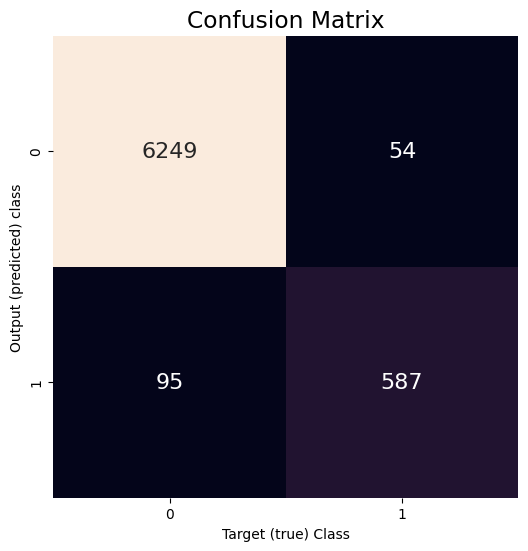

              precision    recall  f1-score   support

       licit       0.99      0.99      0.99      6303
     illicit       0.92      0.86      0.89       682

    accuracy                           0.98      6985
   macro avg       0.95      0.93      0.94      6985
weighted avg       0.98      0.98      0.98      6985



In [17]:
gat_model.load_state_dict(torch.load(os.path.join(config.checkpoints_dir, 'gat_best_model.pth.tar'))['state_dict'])

y_test_preds = test(gat_model, data_train)

# confusion matrix on validation data
conf_mat = confusion_matrix(data_train.y[data_train.val_idx].detach().cpu().numpy(), y_test_preds[valid_idx].cpu())

plt.subplots(figsize=(6,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)
plt.xlabel('Target (true) Class'); plt.ylabel('Output (predicted) class'); plt.title('Confusion Matrix')
plt.show();

print(classification_report(data_train.y[data_train.val_idx].detach().cpu().numpy(),
                            y_test_preds[valid_idx].cpu(),
                            target_names=['licit', 'illicit']))